# Reduced sea ice extent and implications for nutrient availibity in the Arctic:<br> A case study of the Laptev Sea<br>
### Jessica Burger [brgjes006@myuct.ac.za]<br>
#### Group 4: Assisted by Antoine Haddon


### 1.0 Abstract

### 2.0 Introduction<br>
Retreating summertime sea ice cover in the Arctic has occured concurrrently with increased primary productivity over the recent past (Arrigo and van Dijken, 2015). This has been attributed to a number of factors, some of which include increased light penetration (Arrigo et al., 2008) and lengthening of the phytoplankton growing season (Arrigo and van Dijken, 2015).<br> In sunlit surface waters, primary productivity can be limited by nutrient availability (Laukert et al., 2022). In Arctic shelf regions, terrigenous nutrient inputs from land exert a strong control on nutrient availability in addition to vertical mixing, supporting approximately one third of current Arctic ocean net primary production (Terhaar et al., 2021). <br> Despite the generally observed trends and reduction in sea ice extent, some coastal areas of the Arctic have experienced a decline in primary productivity (Ardyna and Arrigo et al., 2020). It remains unclear how this inconsistent phytoplankton repsonse is linked to stratification and nutrient cycling (Laukert et al., 2022). However, it suggests that a better understanding of the controlling mechanisms in shelf regions is required, to assess ecosystem functioning and how it might change under future climate scenarios.<br> The Laptev Sea recieves large amounts of fresh water and nutrients from the Lena River and is the main source region for the Transpolar Drift (TPD), exporting nutrients to the central Arctic basin (Paffrath et al., 2021). As such, the Laptev sea is a key region for investigating nutrient dynamics on the Siberian Shelf.<br> This report investigates seasonal and long term trends in sea ice extent as observed from satellites and compares observations with two CMIP6 models. Further more, CMIP6 model output is used to investigate the relationship between sea ice extent and nutrient availabilty (here: surface nitrate (NO$_{3}^{-}$) concentrations).      


### 3.0 Methods<br>
This report makes use of both observations and model data. High resolution (6.35 km) daily satellite derived sea ice concentration data was obtained from the AMSR2 and AMSR-E satellite products (Melsheimer & Spreen (2019a & b)), with data available for the years 2002 to 2019. A function was  defined to import the data, create a time variable and produce monthly netcdf files from the daily data (see Supplementary Material).<br> 
The CMIP6 models investigated were CNRM and UKESM. In both cases the historical runs were imported with data available for years 1850 to 2014. The variables of interest were sea ice concentration and nitrate concentration.


#### 3.1 Packages<br> 
First, all useful packages were imported.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime, timedelta
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake
import cftime

All available sea ice concentration data are imported and combined to form a single dataset.<br>
The co-ordinates of the satellite data needed to be converted to latitude and longitude before any areas of interest could be selected.<br> Finally, the sea ice extent is calculated, bearing in mind that all grid cells are the same size (6.25 km x 6.25 km). Only grid cells with sea ice concentrations greater than 15% were considered. 

#### 3.2 Satellite sea ice data

In [40]:
# Import all satellite observations
sat = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [41]:
# Convert co-ordinates in satellite data from x and y to latitude and longitude
# We want the output coordinates in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')
# The input coordinates are in meters on a North Polar Stereographic grid 
projIn = pyproj.Proj(init='epsg:3411', preserve_units=True)
xx, yy = np.meshgrid( sat.x.values, sat.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
sat['lon'] = (('y','x'),lon)
sat['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_343/1579399248.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tra

In [42]:
# Select area of interest: Laptev Sea on the Siberian Shelf
sat_SS = sat.where((sat.lon>= 100) & (sat.lon<= 160) & (sat.lat<= 80) & (sat.lat>= 70), drop = True) 

In [43]:
# Compute the sea ice extent (km^2) from sea ice concentration for the Siberian Sea
area = 6.25**2 # The satellite data grid cell sizes are the same (resolution of 6.25 km^2)
# We count the grid cells which have a sea ice concentration >15% and multiply by the area
with ProgressBar():
    iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area).compute()
iceExt=xr.where(iceExt>0,iceExt,np.NaN)

[########################################] | 100% Completed | 193.31 s


In [7]:
# Creat 2-dimensinal arrays of time and sea ice extent
ys = np.unique(sat_SS.time.dt.year) #x axis = years
doy= np.arange(150,330) #y axis = day of years 
t2d = np.array([
    [np.datetime64(str(y)) + np.timedelta64(d, 'D') for d in doy ] 
        for y in ys])

In [8]:
ice2d = np.array([
        [ iceExt.sel(time=d) if d in iceExt.time else np.NaN for d in y ]
            for y in t2d ])

#### 3.3 CMIP6 model data

Next, all relevant CMIP6 model data were imported. Datasets were created for UKESM and CNRM areacello, no3 and siconc.<br>
The processing methods are subdivided into each variable below:

In [ ]:
# To include model data for comparison open cmip6 online catalogue
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

In [ ]:
# We are interested in historical data from CNRM and UKESM with variables: siconc, no3 and areacello
cat = col.search(source_id=['CNRM-ESM2-1','UKESM1-0-LL'], 
                 experiment_id=['historical','piControl'], table_id=['SImon','Omon','Ofx'], 
                 variable_id=['siconc','no3','areacello']) 
                 #member_id=['r1i1p1f1'])

In [ ]:
# Create dictionary from the list of datasets we found
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})

In [ ]:
dset_dict.keys()

In [ ]:
#Create datasets for each model and each variable of interest
cnrm_area = dset_dict[list(dset_dict.keys())[1]]
cnrm_si = dset_dict[list(dset_dict.keys())[5]]
cnrm_no3 = dset_dict[list(dset_dict.keys())[8]]
uk_area = dset_dict[list(dset_dict.keys())[2]]
uk_si = dset_dict[list(dset_dict.keys())[6]]
uk_no3 = dset_dict[list(dset_dict.keys())[7]]

#### CMIP6 Areacello

In [ ]:
# Select region of interest from the Areacello variable
cnrm_SS = cnrm_area.areacello.where((cnrm_area.lat>=70) & (cnrm_area.lat<=80) & (cnrm_area.lon <= 160) 
                                    & (cnrm_area.lon >= 100), drop = True)
cnrm_SS = cnrm_SS.isel(member_id = 0) #for cnrm select one member ID
uk_SS = uk_area.areacello.where((uk_area.latitude>=70) & (uk_area.latitude<=80) & (uk_area.longitude <= 160) 
                                & (uk_area.longitude >= 100), drop = True)
uk_SS = uk_SS.isel(member_id = 0) #for ukesm select one member ID

#### CMIP6 Nitrate

In [ ]:
# Select the surface nitrate concentration from CNRM for the Laptev Sea and average over the ensembles
cnrm_no3_SS = cnrm_no3.isel(lev = 0).where((cnrm_no3.lat>=70) & (cnrm_no3.lat<=80) & (cnrm_no3.lon >=100) 
            & (cnrm_no3.lon <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)
# Select the surface nitrate concentration from UKESM for the Siberian Sea and average over the ensembles
uk_no3_SS = uk_no3.isel(lev = 0).where((uk_no3.latitude>=70) & (uk_no3.latitude<=80) & (uk_no3.longitude >=100) 
            & (uk_no3.longitude <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)

In [ ]:
# Nitrate concentration needs to be weighted by the area of the cells in the model 
cnrm_no3_w = (cnrm_SS*cnrm_no3_SS).sum(dim=('y','x'))/cnrm_SS.sum(dim=('y','x'))
uk_no3_w = (uk_SS*uk_no3_SS).sum(dim=('j','i'))/uk_SS.sum(dim=('j','i'))

In [ ]:
# Calculate the mean and standard deviation of the monthly nitrate concentration from cnrm for the 
# time period overlapping with the observations: 2002 to 2014
cnrm_no3_obs = cnrm_no3_w.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
cnrm_no3_obs_sd = cnrm_no3_w.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])

In [ ]:
# Calculate the mean and standard deviation of the monthly nitrate concentration from cnrm for the 
# historical time period: 1850 to 2001
cnrm_no3_hist = cnrm_no3_w.sel(time = slice('1850','2001')).groupby('time.month').mean(dim=['time'])
cnrm_no3_hist_sd = cnrm_no3_w.sel(time = slice('1850','2001')).groupby('time.month').std(dim=['time'])

#### CMIP6 Sea ice 

In [ ]:
# Select sea ice concentration from CNRM for the Laptev Sea and average over the ensembles
cnrm_si_SS = cnrm_si.where((cnrm_si.lat>=70) & (cnrm_si.lat<=80) & (cnrm_si.lon >=100) 
            & (cnrm_si.lon <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)
# Select sea ice concentration from UKESM for the Laptev Sea and average over the ensembles
uk_si_SS = uk_si.where((uk_si.latitude>=70) & (uk_si.latitude<=80) & (uk_si.longitude >=100) 
            & (uk_si.longitude <= 160),drop = True).mean(dim = ['member_id'], keep_attrs=True)

In [ ]:
# Calculate the extent for each model
cnrm_iceExt = ((xr.where(cnrm_si_SS['siconc']>15, 1.,0))*cnrm_SS).sum(dim=['y','x'])
uk_iceExt = ((xr.where(uk_si_SS['siconc']>15, 1.,0))*uk_SS).sum(dim=['j','i'])
# Calculate the extent from Satellite data
sat_iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area).compute()

In [ ]:
# To compare Satellite data with model data for overlapping period: 2002-2014
# calculate the mean and standard deviation of the monthly sea ice extent from cnrm and ukesm for the 
# time period overlapping with the observations: 2002 to 2014
cnrm_iceExt_obs = cnrm_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
uk_iceExt_obs = uk_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
sat_iceExt_obs = sat_iceExt.sel(time = slice('2002','2014')).groupby('time.month').mean(dim=['time'])
# Find standard deviations:
cnrm_iceExt_obs_sd = cnrm_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])
uk_iceExt_obs_sd = uk_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])
sat_iceExt_obs_sd = sat_iceExt.sel(time = slice('2002','2014')).groupby('time.month').std(dim=['time'])

In [ ]:
# Calculate the mean and standard deviation of the monthly sea ice extent from cnrm for the 
# historical time period: 1850 to 2001
cnrm_iceExt_hist = cnrm_iceExt.sel(time = slice('1850','2001')).groupby('time.month').mean(dim=['time'])
cnrm_iceExt_hist_sd = cnrm_iceExt.sel(time = slice('1850','2001')).groupby('time.month').std(dim=['time'])

#### Results<br>
According to observations, the Laptev Sea has experienced a lengthening of the open water period over the last two decades (2002 to 2019) (Fig. 1 blue shaded area). Figure 1 shows that over time, the sea ice has started to melt sooner in July and reform later in October, as evidenced by a sea ice extent of less than 200 000 km$^{2}$ visible during these time periods.

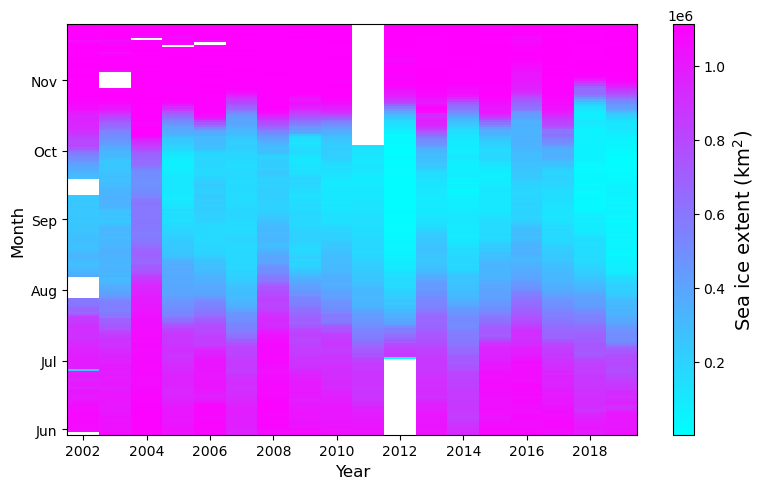

In [11]:
#Create figure 1
fig, ax = plt.subplots(figsize = (8,5))
pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               ice2d.T,
                cmap=plt.colormaps['cool'])
cbar = fig.colorbar(pl)
cbar.set_label(r'Sea ice extent (km$^{2}$)', size = 14)
fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())
ax.set_ylabel('Month', size = 12)
ax.set_xlabel('Year', size = 12)
fig.tight_layout()
plt.savefig('Heatmap SS.png')

 Figure 1: Heat map indicating the timing of sea ice melt and reformation over 18 years from 2002 to 2019.<br>The color bar (blue to purple) shows sea ice extent (km$^{2}$).

When comparing sea ice extent from CNRM and UKESM to satellite observations, we see that the seasonal variability is captured moderately well by both models (Fig. 2). Like observations both models show a September minimum sea ice extent, however the observations suggest that sea ice extent begins to decline around May, while initial sea ice melt is observed later in both models (June and July for UKESM and CNRM, respectively). On the other hand, maximum sea ice extent is similarly achieved again by November in the observations and both models. In both models, the summertime sea ice extent is largely overestimated in comparison to the observations.  

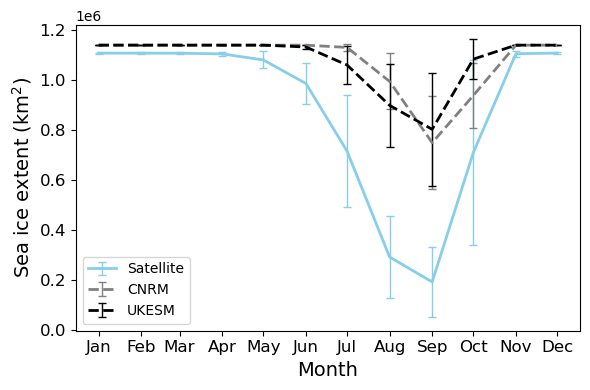

In [53]:
# Creat figure 2
fig, ax = plt.subplots(figsize = (6,4))
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            sat_iceExt_obs, yerr = sat_iceExt_obs_sd, capsize = 3, elinewidth = 1, color='skyblue',
            lw = 2, label = 'Satellite', linestyle = '-')
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            cnrm_iceExt_obs/1e6, yerr = cnrm_iceExt_obs_sd/1e6, capsize = 3, elinewidth = 1, color='Grey',
            lw = 2, label = 'CNRM', linestyle = '--')
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in sat_iceExt_obs.month.values],
            uk_iceExt_obs/1e6, yerr = uk_iceExt_obs_sd/1e6, capsize = 3, elinewidth = 1, color='k',
            lw = 2, label = 'UKESM', linestyle = '--')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel(r'Sea ice extent (km${^2})$', fontsize=14)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.legend(loc = 'best')
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())
plt.tight_layout()

Figure 2: Monthly averaged sea ice extent from 2002 to 2014 in CNRM (broken grey line) and UKESM (broken black line)<br>
in comparison to satellite data (solid blue line).

Given that the sea ice extent from both models are so similar to each other, I chose to work only with one of the models (CNRM) in the analyses below.<br> Figure 3 compares the monthly averaged sea ice extent (grey) and surface nitrate concentration (pink) from CNRM for the Laptev Sea. The historical time period from 1850 to 2001 is shown by broken lines and the more recent time period, which overlaps with the observational data (2002 to 2014), is shown by the solid lines. From the CNRM sea ice extent, one clearly observes a reduction in summertime sea ice extent for the recent period in comparison to the historical period. From the CNRM surface nitrate concentrations, one observes a reduction in the quantity of nitrate available during the summer period. In both cases (sea ice extent and nitrate availabilty), there is no significant change in seasonality between the historical and recent time periods. Based on CNRM, the surface nitrate concentration in the Laptev Sea starts to decline when sea ice starts to melt. Both are at a minimum in September.<br>

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:273: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))


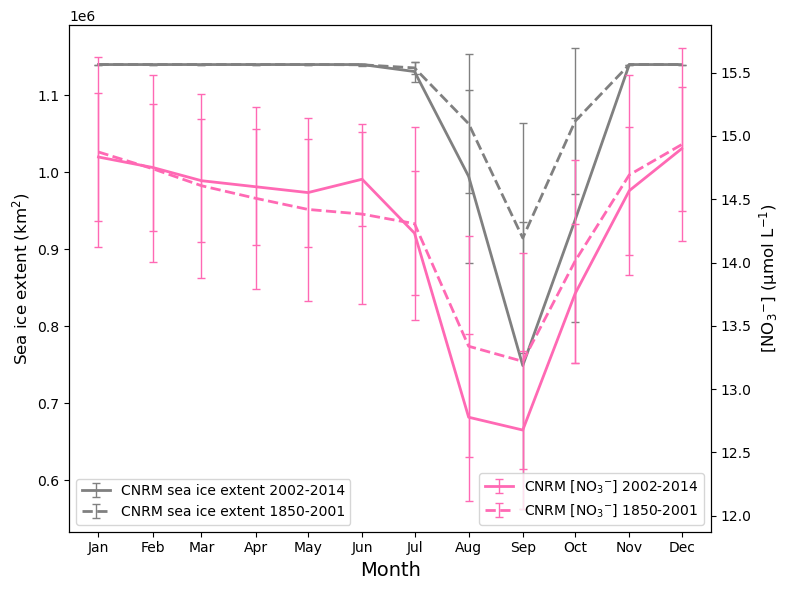

In [50]:
# Create figure 3
fig, ax = plt.subplots(figsize = (8,6))
#with ProgressBar():
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in cnrm_iceExt_obs.month.values],
            cnrm_iceExt_obs/1e6, yerr = cnrm_iceExt_obs_sd/1e6, capsize = 3, elinewidth = 1,
                color='grey',
                lw = 2, label = 'CNRM sea ice extent 2002-2014',
           linestyle = '-')
ax.errorbar([datetime.strptime(str(m).zfill(2), '%m') for m in cnrm_iceExt_obs.month.values],
            cnrm_iceExt_hist/1e6, yerr = cnrm_iceExt_hist_sd/1e6, capsize = 3, elinewidth = 1,
                color='grey',
                lw = 2, label = 'CNRM sea ice extent 1850-2001',
           linestyle = '--')
ax2 = ax.twinx()
ax2.errorbar(x = [datetime.strptime(str(m).zfill(2), '%m') for m in cnrm_iceExt_obs.month.values],
            y = cnrm_no3_obs['no3']*1e3, yerr = cnrm_no3_obs_sd['no3']*1e3, capsize = 3, elinewidth = 1,
                color='hotpink',
                lw = 2, label = r'CNRM [NO${_3}^{-}$] 2002-2014',
           linestyle = '-')
ax2.errorbar(x = [datetime.strptime(str(m).zfill(2), '%m') for m in cnrm_iceExt_obs.month.values],
            y = cnrm_no3_hist['no3']*1e3, yerr = cnrm_no3_hist_sd['no3']*1e3, capsize = 3, elinewidth = 1,
                color='hotpink',
                lw = 2, label = r'CNRM [NO${_3}^{-}$] 1850-2001',
           linestyle = '--')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel(r'Sea ice extent (km${^2})$', fontsize=12)
ax2.set_ylabel(r'[NO${_3}^{-}$] (μmol L$^{-1})$', fontsize=12)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)
ax.legend(loc = 'best')
ax2.legend(loc = 'lower right')
fmt = mdate.DateFormatter('%b')
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdate.MonthLocator())
plt.tight_layout()

Figure 3. Monthly averaged sea ice extent (grey) and surface nitrate concentrations (pink) for historical (broken line) and recent (solid line) time periods from CNRM, for the Laptev Sea area.

To explore any variation in the spatial distribution of sea ice and surface nitrate between the historical and recent time periods, the data are plotted on maps of the Laptev Sea in Figure 4 below. For the purpose of this comparison, the month of September was plotted in all cases, as this is when the least ice and nitrate is present, such that nitrate could potentially limit primary production. 

In [52]:
# Here I make new data sets grouped by month and select for September, when we see a minimum in both sea ice and nitrate. 
cnrm_si_SS_m = cnrm_si_SS.groupby('time.month')
cnrm_no3_SS_m = cnrm_no3_SS.groupby('time.month')
# Here I separate the datasets into historical and recent time periods, the recent time period defined by the period of overlap with observations.
si_past = cnrm_si_SS_m[9]['siconc'][:-13]
si_pres = cnrm_si_SS_m[9]['siconc'][-13:]
no3_past = cnrm_no3_SS_m[9]['no3'][:-13]
no3_pres = cnrm_no3_SS_m[9]['no3'][-13:]

In [53]:
import Functions as f # Defined a function to include some commonly utilised map features, which is loaded here.
%load_ext autoreload
%autoreload 2

Text(0.5, 1.0, 'September 2002-2014')

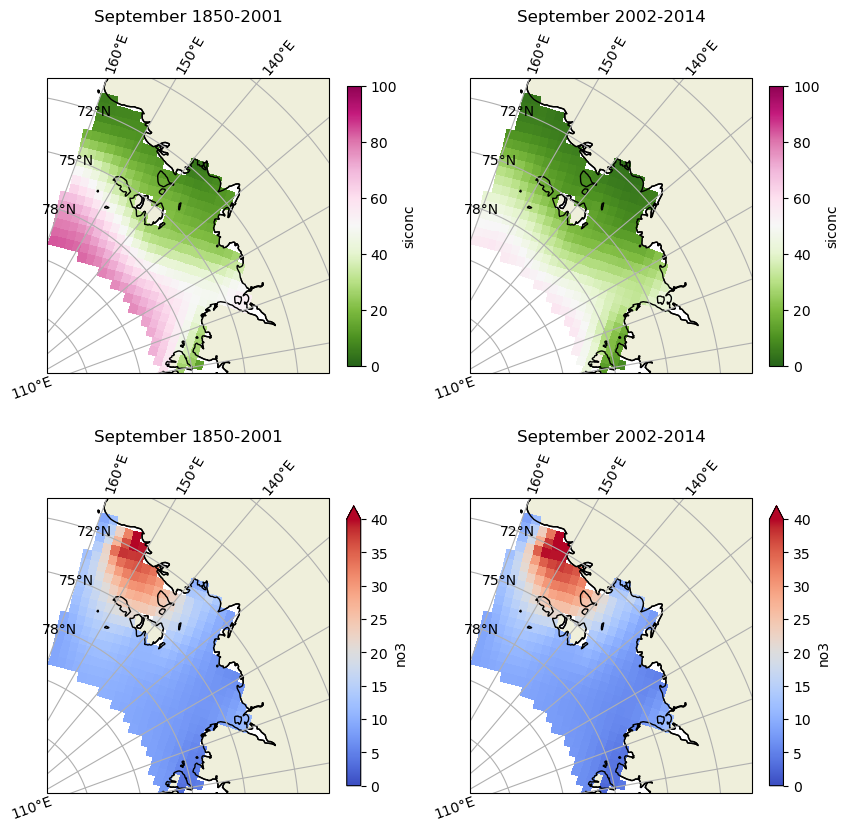

In [54]:
# Creat figure 4
extent = [100,160, 80, 70]
fig = plt.figure(1, figsize=[10,10])

ax = plt.subplot(2, 2, 1, projection=ccrs.NorthPolarStereo())
f.mapfeatures(ax,extent)
ax = si_past.mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='PiYG_r',
    vmax = 100, vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('A: September 1850-2001')

ax = plt.subplot(2, 2, 2, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = si_pres.mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='PiYG_r',
    vmax = 100, vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('B: September 2002-2014')

ax = plt.subplot(2, 2, 3, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = (no3_past*1e3).mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='coolwarm',
    vmax =40 , vmin = 0,                                     
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('C: September 1850-2001')

ax = plt.subplot(2, 2, 4, projection=ccrs.NorthPolarStereo() )
f.mapfeatures(ax,extent)
ax = (no3_pres*1e3).mean(dim = ['time']).plot.pcolormesh(x='lon', y='lat',
    cmap='coolwarm',
    vmax =40 , vmin = 0,
    transform = ccrs.PlateCarree(),
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8})
plt.title('D: September 2002-2014')

Figure 4: A comparison of sea ice concentration (top row) and nitrate concentration (bottom row) for the present period of overlap<br>
with observations (2002-2014) (right column) and past period (1850-2001) (left column) for September, the month of minimum sea ice and nutrient availabilty.

### Discusssion and conclusions

### Acknowledgements

### References